<a href="https://colab.research.google.com/github/pasdptt/PasdPublicNB/blob/master/PySaprk_Testing_%26_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Spark + import lib + start spark session



In [1]:
!apt-get update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,992 kB]
Hit:13 http://ppa.la

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark

#Install extra lib(s)
!pip install -q xlrd
!pip install -q kaggle
!pip install -q kora

#import and set environment for spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

import kora
import pandas as pd

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import *

SPARK_URL = "local[*]"

spark = SparkSession.builder.master(SPARK_URL).getOrCreate()

# Check the pyspark version
import pyspark
print(pyspark.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 46 kB/s 
     |████████████████████████████████| 199 kB 60.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=87039e20dba2ef48199ba640b63ceb6197ef84063c93cea267bf8c9edb5a6683
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
     |████████████████████████████████| 57 kB 2.7 MB/s 
     |████████████████████████████████| 1.6 MB 10.5 MB/s 
3.3.0


In [3]:
pip install pyspark_dist_explore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row

from pyspark.sql.functions import lit
from pyspark import SparkConf
from pyspark import SparkContext
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

#sc = pyspark.SparkContext()
sqlContext = pyspark.SQLContext(sc)
%matplotlib inline

/content/spark-3.3.0-bin-hadoop3/python/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


##Getting sample data

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

#Adding API code here
!kaggle datasets download -d claudiodavi/superhero-set

!unzip /content/superhero-set.zip  && rm /content/superhero-set.zip

Mounted at /content/gdrive
  0% 0.00/31.7k [00:00<?, ?B/s]
100% 31.7k/31.7k [00:00<00:00, 27.4MB/s]
Archive:  /content/superhero-set.zip
  inflating: heroes_information.csv  
  inflating: super_hero_powers.csv   


In [6]:
file_path = "./heroes_information.csv"
df_hero_indi = spark.read.options(header="true",inferschema = "true").csv(file_path)

file_path = "./super_hero_powers.csv"
df_hero_power = spark.read.options(header="true",inferschema = "true").csv(file_path)

df_hero_indi.show()
df_hero_power.show()

+---+-----------------+------+---------+-----------------+----------+------+-----------------+----------+---------+------+
|_c0|             name|Gender|Eye color|             Race|Hair color|Height|        Publisher|Skin color|Alignment|Weight|
+---+-----------------+------+---------+-----------------+----------+------+-----------------+----------+---------+------+
|  0|           A-Bomb|  Male|   yellow|            Human|   No Hair| 203.0|    Marvel Comics|         -|     good| 441.0|
|  1|       Abe Sapien|  Male|     blue|    Icthyo Sapien|   No Hair| 191.0|Dark Horse Comics|      blue|     good|  65.0|
|  2|         Abin Sur|  Male|     blue|          Ungaran|   No Hair| 185.0|        DC Comics|       red|     good|  90.0|
|  3|      Abomination|  Male|    green|Human / Radiation|   No Hair| 203.0|    Marvel Comics|         -|      bad| 441.0|
|  4|          Abraxas|  Male|     blue|    Cosmic Entity|     Black| -99.0|    Marvel Comics|         -|      bad| -99.0|
|  5|    Absorbi

##Create sample data

In [7]:
# Create some data in a Spark DataFrame:
n_observations = 200

random_dist_1 = np.random.logistic(100, 1000, n_observations)
random_dist_2 = np.random.logistic(400, 500, n_observations)
age_dist_1 = 20 * np.random.randn(n_observations) + 40
age_dist_2 = 15 * np.random.randn(n_observations) + 30

list_male = [('M', rand_value, age_dist_1[i]) for i, rand_value in enumerate(random_dist_1)]
list_female = [('F', rand_value, age_dist_2[i]) for i, rand_value in enumerate(random_dist_2)]

list_male_female = list_male + list_female

rdd = sc.parallelize(list_male_female)
transactions = rdd.map(lambda x: Row(gender=x[0], amount=float(x[1]), age=float(x[2])))
transactions_df = sqlContext.createDataFrame(transactions)

In [8]:
transactions_df.show()

+------+-------------------+------------------+
|gender|             amount|               age|
+------+-------------------+------------------+
|     M|  894.2833931434769| 75.40362169090939|
|     M|  3724.727027252546|31.613092127908622|
|     M|  -921.563465816816| 26.48889704002515|
|     M|-131.33435768392374|15.809364255151472|
|     M|-2516.3971685594574|54.052767132807354|
|     M|  3210.918499795724|38.569409615964496|
|     M| -676.9174774906865| 26.66601505866253|
|     M|-1781.7750048602288|11.828382254350174|
|     M|-1415.1043216095695|55.806279241514126|
|     M|  487.7844842873526|11.943433242522495|
|     M| 1982.6042880634118|36.826679147759116|
|     M| 1745.3355194252354| 42.97970508516664|
|     M| 505.42330204997154| 26.45742269942459|
|     M| 1536.5416494480378| 42.84502318710603|
|     M|-1256.0655035148866| 19.22029687172828|
|     M| -690.4897456192073| 40.63249659445772|
|     M| -887.8248138088038|  71.2857269429403|
|     M|  5200.171712834311| 51.49124773

In [9]:
transactions_df.count()

400

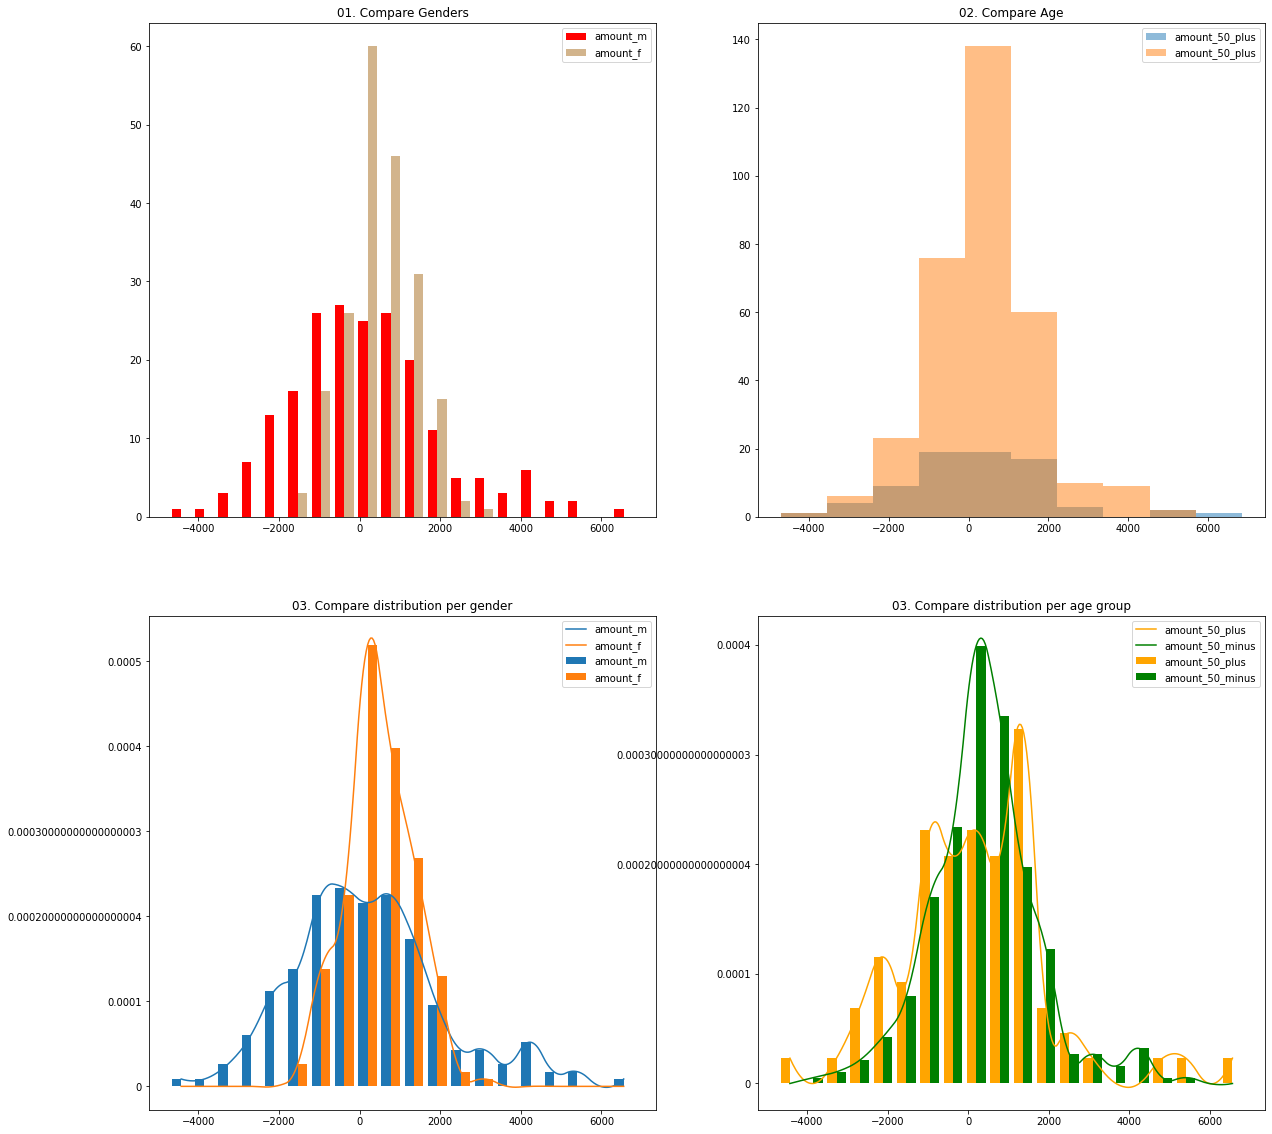

In [10]:
# Create some selections on this data

filtered_by_gender_m = transactions_df.filter(F.col('gender') == 'M').select(F.col('amount').alias('amount_m'))
filtered_by_gender_f = transactions_df.filter(F.col('gender') == 'F').select(F.col('amount').alias('amount_f') )                                                                            
filtered_by_age_50_plus = transactions_df.filter(F.col('age') > 50).select(F.col('amount').alias('amount_50_plus'))
filtered_by_age_50_minus = transactions_df.filter(F.col('age') <= 50).select(F.col('amount').alias('amount_50_minus'))                                                                             
                                                                             
# Create the plots
    
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(20, 20)

# Use the hist function to plot histograms on the Axes
hist(axes[0, 0], [filtered_by_gender_m, filtered_by_gender_f], bins = 20, color=['red', 'tan'])
axes[0, 0].set_title('01. Compare Genders')
axes[0, 0].legend()

hist(axes[0, 1], [filtered_by_age_50_plus, filtered_by_age_50_minus], overlapping=True)
axes[0, 1].set_title('02. Compare Age')
axes[0, 1].legend()

# Use the distplot function to plot (scaled) histograms + density plots on the Axes
distplot(axes[1, 0], [filtered_by_gender_m, filtered_by_gender_f], bins=20)
axes[1, 0].set_title('03. Compare distribution per gender')
axes[1, 0].legend()

distplot(axes[1, 1], [filtered_by_age_50_plus, filtered_by_age_50_minus], bins=20, color=['orange', 'green'])
axes[1, 1].set_title('03. Compare distribution per age group')
_ = axes[1, 1].legend()

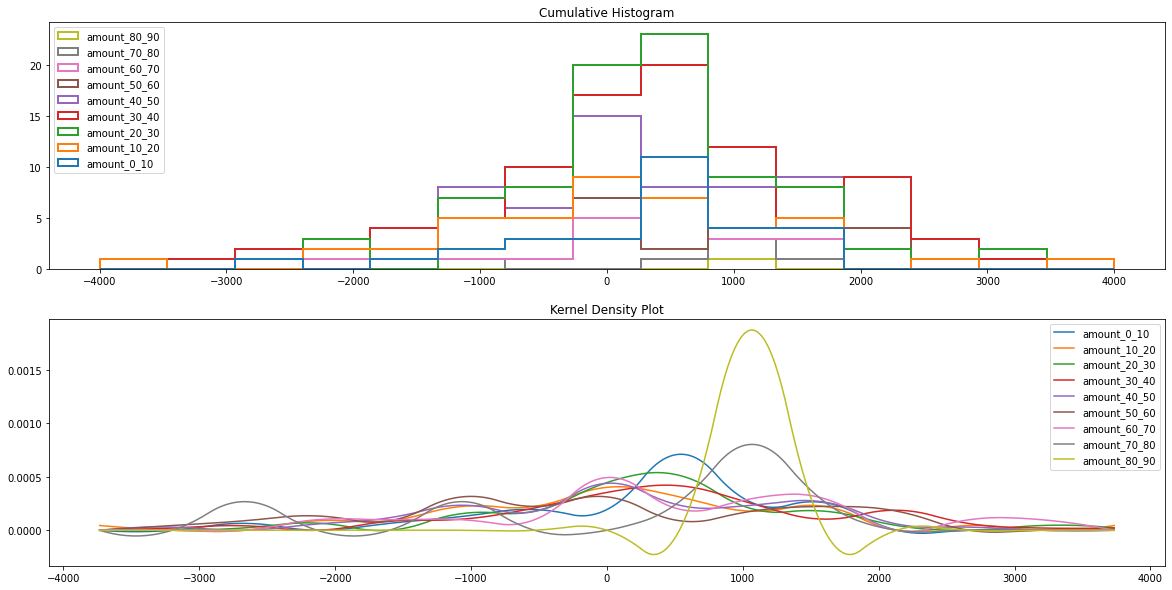

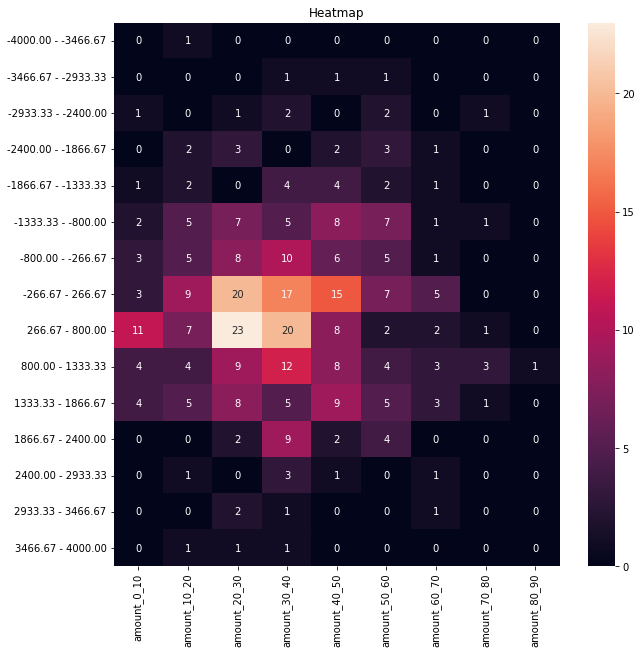

In [11]:
age_hist = Histogram(range=(-4000, 4000), bins=15)

# Create a histogram for different age groups
for age in range(0, 90, 10):
    age_hist.add_data(
        transactions_df.
        filter((F.col('age') > age) & (F.col('age') <= age+10)).
        select(F.col('amount').alias('amount_%d_%d' % (age, age+10)))
    )

fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(20, 10)    

age_hist.plot_hist(axes[0], histtype='step', linewidth=2.0, fill=False, cumulative=False) # The Histogram is build here
age_hist.plot_density(axes[1]) # The density plot is created from the already build histogram

# Set the legends
axes[0].legend(loc = 'upper left' )
axes[0].set_title('Cumulative Histogram')
axes[1].legend()
axes[1].set_title('Kernel Density Plot')

age_hist_pd_df = age_hist.to_pandas() # Again the histograms don't need to be recalculated. 

# Create a heatmap from the Pandas Dataframe

fig, axes = plt.subplots()
fig.set_size_inches(10, 10)    
ax = sns.heatmap(age_hist_pd_df, annot=True, ax=axes)
_ = ax.set_title('Heatmap')

#Correlation

In [12]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

data = [(Vectors.sparse(4, [(0, 1.0), (3, -2.0)]),),
        (Vectors.dense([4.0, 5.0, 0.0, 3.0]),),
        (Vectors.dense([6.0, 7.0, 0.0, 8.0]),),
        (Vectors.sparse(4, [(0, 9.0), (3, 1.0)]),)]
df = spark.createDataFrame(data, ["features"])

r1 = Correlation.corr(df, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

r2 = Correlation.corr(df, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.05564149,        nan, 0.40047142],
             [0.05564149, 1.        ,        nan, 0.91359586],
             [       nan,        nan, 1.        ,        nan],
             [0.40047142, 0.91359586,        nan, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.10540926,        nan, 0.4       ],
             [0.10540926, 1.        ,        nan, 0.9486833 ],
             [       nan,        nan, 1.        ,        nan],
             [0.4       , 0.9486833 ,        nan, 1.        ]])


In [13]:
df.show()

+--------------------+
|            features|
+--------------------+
|(4,[0,3],[1.0,-2.0])|
|   [4.0,5.0,0.0,3.0]|
|   [6.0,7.0,0.0,8.0]|
| (4,[0,3],[9.0,1.0])|
+--------------------+



In [14]:
#Additional example
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

matrix.collect()[0]["pearson({})".format(vector_col)].values

array([1.        , 0.05564149,        nan, 0.40047142, 0.05564149,
       1.        ,        nan, 0.91359586,        nan,        nan,
       1.        ,        nan, 0.40047142, 0.91359586,        nan,
       1.        ])

##Hypothesis Testing

In [15]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest

data = [(0.0, Vectors.dense(0.5, 10.0)),
        (0.0, Vectors.dense(1.5, 20.0)),
        (1.0, Vectors.dense(1.5, 30.0)),
        (0.0, Vectors.dense(3.5, 30.0)),
        (0.0, Vectors.dense(3.5, 40.0)),
        (1.0, Vectors.dense(3.5, 40.0))]
df = spark.createDataFrame(data, ["label", "features"])

r = ChiSquareTest.test(df, "features", "label").head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

pValues: [0.6872892787909721,0.6822703303362126]
degreesOfFreedom: [2, 3]
statistics: [0.75,1.5]


##Summarizer

In [16]:
from pyspark.ml.stat import Summarizer
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

df = sc.parallelize([Row(weight=1.0, features=Vectors.dense(1.0, 1.0, 1.0)),
                     Row(weight=0.0, features=Vectors.dense(1.0, 2.0, 3.0))]).toDF()
df.show()

# create summarizer for multiple metrics "mean" and "count"
summarizer = Summarizer.metrics("mean", "count")

# compute statistics for multiple metrics with weight
df.select(summarizer.summary(df.features, df.weight)).show(truncate=False)

# compute statistics for multiple metrics without weight
df.select(summarizer.summary(df.features)).show(truncate=False)

# compute statistics for single metric "mean" with weight
df.select(Summarizer.mean(df.features, df.weight)).show(truncate=False)

# compute statistics for single metric "mean" without weight
df.select(Summarizer.mean(df.features)).show(truncate=False)

+------+-------------+
|weight|     features|
+------+-------------+
|   1.0|[1.0,1.0,1.0]|
|   0.0|[1.0,2.0,3.0]|
+------+-------------+

+-----------------------------------+
|aggregate_metrics(features, weight)|
+-----------------------------------+
|{[1.0,1.0,1.0], 1}                 |
+-----------------------------------+

+--------------------------------+
|aggregate_metrics(features, 1.0)|
+--------------------------------+
|{[1.0,1.5,2.0], 2}              |
+--------------------------------+

+--------------+
|mean(features)|
+--------------+
|[1.0,1.0,1.0] |
+--------------+

+--------------+
|mean(features)|
+--------------+
|[1.0,1.5,2.0] |
+--------------+



#Sampling

In [17]:
list = [(2147481832,23355149,1),(2147481832,973010692,1),(2147481832,2134870842,1),(2147481832,541023347,1),(2147481832,1682206630,1),(2147481832,1138211459,1),(2147481832,852202566,1),(2147481832,201375938,1),(2147481832,486538879,1),(2147481832,919187908,1),(214748183,919187908,1),(214748183,91187908,1)]
df = spark.createDataFrame(list, ["x1","x2","x3"])
df.show()

+----------+----------+---+
|        x1|        x2| x3|
+----------+----------+---+
|2147481832|  23355149|  1|
|2147481832| 973010692|  1|
|2147481832|2134870842|  1|
|2147481832| 541023347|  1|
|2147481832|1682206630|  1|
|2147481832|1138211459|  1|
|2147481832| 852202566|  1|
|2147481832| 201375938|  1|
|2147481832| 486538879|  1|
|2147481832| 919187908|  1|
| 214748183| 919187908|  1|
| 214748183|  91187908|  1|
+----------+----------+---+



In [18]:
df.count()

12

In [19]:
df.groupBy("x1").count().show()

+----------+-----+
|        x1|count|
+----------+-----+
|2147481832|   10|
| 214748183|    2|
+----------+-----+



In [20]:
seed = 12

##Normal Sampling

In [21]:
NormalSam = df.sample(False, 0.5, seed)
NormalSamRep = df.sample(True, 0.5, seed)

NormalSam.show()
NormalSamRep.show()

+----------+----------+---+
|        x1|        x2| x3|
+----------+----------+---+
|2147481832|  23355149|  1|
|2147481832| 541023347|  1|
|2147481832|1682206630|  1|
|2147481832|1138211459|  1|
|2147481832| 852202566|  1|
|2147481832| 486538879|  1|
| 214748183| 919187908|  1|
+----------+----------+---+

+----------+----------+---+
|        x1|        x2| x3|
+----------+----------+---+
|2147481832| 973010692|  1|
|2147481832|2134870842|  1|
|2147481832| 541023347|  1|
|2147481832|1138211459|  1|
|2147481832| 201375938|  1|
| 214748183| 919187908|  1|
+----------+----------+---+



##Stratified Sampling

In [ ]:
fractions = df.select("x1").distinct().withColumn("fraction", lit(0.5)).rdd.collectAsMap()
print(fractions)                                                            
sampled_df = df.stat.sampleBy("x1", fractions, seed)
sampled_df.show()

{2147481832: 0.5, 214748183: 0.5}
+----------+----------+---+
|        x1|        x2| x3|
+----------+----------+---+
|2147481832|  23355149|  1|
|2147481832| 541023347|  1|
|2147481832|1682206630|  1|
|2147481832|1138211459|  1|
|2147481832| 852202566|  1|
|2147481832| 486538879|  1|
| 214748183| 919187908|  1|
+----------+----------+---+

